In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_bar_igw.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/functions_bar_igw.ipynb

Loadig data

In [6]:
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc" # in numpy .npy format
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_" # including the file name prefix 
path_to_save = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/" # including the file name prefix 

# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset(path_to_input + "01.nc")
ds = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-01T00:30:00')).load()

# Loading Mask
mask = xr.open_dataset(path_to_mask,drop_variables={"x","y"}) 
mask = mask.tmaskutil[0,:,:].values

In [7]:
ssh_hf

<xarray.Dataset> Size: 4GB
Dimensions:                        (y: 853, x: 788, time_counter: 744)
Coordinates:
    lat                            (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
    lon                            (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
  * time_counter                   (time_counter) datetime64[ns] 6kB 2014-01-...
Dimensions without coordinates: y, x
Data variables:
    __xarray_dataarray_variable__  (time_counter, y, x) float64 4GB dask.array<chunksize=(744, 853, 788), meta=np.ndarray>

Mask, Coarsen, axis, grid2D and filled

In [8]:
ssh_hf = ds.ssh_hf.where(mask==1,np.nan) # change false by 1, otherwise everithing is nan
# print('mask: ok')

ssh_hf = ssh_hf.coarsen(x=4, y=4, boundary='trim').mean()
# print('coarsen: ok')

x_axis = Axis(ssh_hf.x.values,is_circle=True)
y_axis = Axis(ssh_hf.y.values,is_circle=True)
# print('x_axis,y_axis: ok') # t_axis no longer needed    

grid = Grid2D(y_axis, x_axis, ssh_hf.values.transpose(0,1))
# print('grid: ok') 

has_converged, filled = fill.gauss_seidel(grid) # we do not need to transpose, cause we are not concern by t_axis
#print('convergence =', has_converged)
# print('filled: ok')

ssh_hf_filled = ssh_hf.copy(deep=True,data=filled) # is it ok?
# print('copy: ok')

To cartesian grid

In [9]:
dx = 10 # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:,0].values,
                                                            ssh_hf_filled.lon[0,:].values,
                                                            dx)

In [10]:
# Create a new DataArray with the filled data
ssh_hf_filled = xr.DataArray(
    data=filled,
    dims=['y', 'x'],
    coords={'y': ssh_hf.y, 'x': ssh_hf.x, 'lat': (['y', 'x'], ssh_hf.lat.data), 'lon': (['y', 'x'], ssh_hf.lon.data)}
)

dx = 10  # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:, 0].values,
                                                         ssh_hf_filled.lon[0, :].values,
                                                         dx)

ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

points = np.column_stack((ssh_hf_filled.lat.data.flatten(), ssh_hf_filled.lon.data.flatten()))
values = ssh_hf_filled.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))

array_cart_ssh = griddata(points, values, target_grid, method='linear')

array_cart_ssh = array_cart_ssh.reshape(ENSLAT2D.shape)

In [11]:
#INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
    
grid = Grid2D(y_axis, x_axis, array_cart_ssh.reshape((i_lat,i_lon)))
has_converged, filled = fill.gauss_seidel(grid)

mask_cart = np.isnan(array_cart_ssh.reshape((i_lat,i_lon)))

cart_ssh_hf = xr.DataArray(data=filled,
                            dims=["y","x"],
                            coords = dict(
                                y=(["y"],np.arange(i_lat)),
                                x=(["x"],np.arange(i_lon))
                            ))

In [12]:
# EXTRACTING BAROTROPIC TIDE # 
cart_ssh_filtered = np.array(extract_bar_tide(cart_ssh_hf.values, dx))

In [13]:
#lon2d, lat2d = np.meshgrid(ssh_hf.lon.values, ssh_hf.lat.values)
lon2d, lat2d = np.meshgrid(ssh_hf.lon[0,:].values, ssh_hf.lat[:,0].values)

In [14]:
# Perform the interpolation
geo_filtered = griddata(
    np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,  
    cart_ssh_filtered.flatten(),                        
    (ssh_hf['lat'].values, ssh_hf['lon'].values),                                       
    method='linear'                                         
)

# Create the new DataArray with the same coordinates as ssh_hf
ssh_bar = xr.DataArray(
    data=geo_filtered, 
    dims=["y", "x"],   # Dimensions should match those of ssh_hf
    coords={"lat": (["y", "x"], ssh_hf['lat'].values), "lon": (["y", "x"], ssh_hf['lon'].values)},  # Coordinates should match those of ssh_hf
    name="ssh_bar"  # Name 
)

/tmp/ipykernel_380677/3098588215.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bar.lon, ssh_bar.lat,ssh_bar, cmap=cmocean.cm.curl)


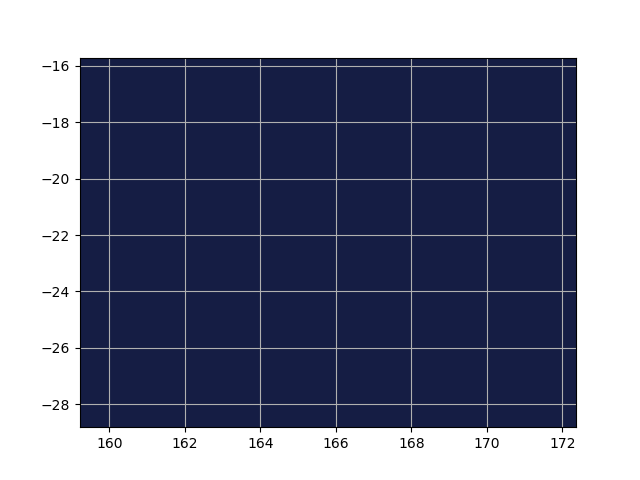

In [15]:
plt.figure()
plt.pcolormesh(ssh_bar.lon, ssh_bar.lat,ssh_bar, cmap=cmocean.cm.curl)
plt.grid(True, which='both')
plt.show()

In [16]:
ssh_hf

<xarray.DataArray 'ssh_hf' (y: 213, x: 197)> Size: 336kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat           (y, x) float32 168kB -28.78 -28.78 -28.78 ... -15.74 -15.74
    lon           (y, x) float32 168kB 159.3 159.3 159.4 ... 172.2 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-01T00:30:00
Dimensions without coordinates: y, x

# Exporting results (ssh_bar)


In [87]:
def process_hour(time_point):
    try:
        # Load the data for the specific hour
        ds = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=time_point).load()
        
        # Apply the mask
        ssh_hf_masked = ds.ssh_hf.where(mask == 1, np.nan)
        
        # Coarsen the data
        ssh_hf_coarsened = ssh_hf_masked.coarsen(x=4, y=4, boundary='trim').mean()
        
        # Create axes and grid
        x_axis = Axis(ssh_hf_coarsened.x.values, is_circle=True)
        y_axis = Axis(ssh_hf_coarsened.y.values, is_circle=True)
        grid = Grid2D(y_axis, x_axis, ssh_hf_coarsened.values.transpose(0, 1))
        
        # Perform Gauss-Seidel fill
        has_converged, filled = fill.gauss_seidel(grid)
        
        # Create the filled DataArray
        ssh_hf_filled = ssh_hf_coarsened.copy(deep=True, data=filled)
        
        # Create Cartesian grid
        dx = 10  # in kilometers
        ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(
            ssh_hf_filled.lat[:, 0].values,
            ssh_hf_filled.lon[0, :].values,
            dx
        )
        
        # Interpolate NaNs
        x_axis = Axis(np.arange(i_lon))
        y_axis = Axis(np.arange(i_lat))
        grid = Grid2D(y_axis, x_axis, array_cart_ssh.reshape((i_lat, i_lon)))
        has_converged, filled = fill.gauss_seidel(grid)
        mask_cart = np.isnan(array_cart_ssh.reshape((i_lat, i_lon)))
        
        cart_ssh_hf = xr.DataArray(
            data=filled,
            dims=["y", "x"],
            coords=dict(
                y=(["y"], np.arange(i_lat)),
                x=(["x"], np.arange(i_lon))
            )
        )
        
        # Extract barotropic tide
        cart_ssh_filtered = np.array(extract_bar_tide(cart_ssh_hf.values, dx))
        
        # Perform interpolation
        geo_filtered = griddata(
            np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,
            cart_ssh_filtered.flatten(),
            (ssh_hf['lat'].values, ssh_hf['lon'].values),
            method='linear'
        )
        
        # Create the new DataArray
        ssh_bar = xr.DataArray(
            data=geo_filtered,
            dims=["y", "x"],
            coords={"lat": (["y", "x"], ssh_hf['lat'].values), "lon": (["y", "x"], ssh_hf['lon'].values)},
            name="ssh_bar"
        )
        
        return ssh_bar
    except Exception as e:
        print(f"Error processing {time_point}: {e}")
        return None

# Function to generate time points for a given month and year
def generate_time_points(year, month):
    start_date = f'{year}-{month:02d}-01T00:30:00'
    end_day = monthrange(year, month)[1]
    end_date = f'{year}-{month:02d}-{end_day}T23:30:00'
    time_points = pd.date_range(start=start_date, end=end_date, freq='H')
    return time_points

# Set the range of months and the year
start_month = 6
end_month = 12
year = 2014

# Paths (update these with your actual paths)
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc" # in numpy .npy format
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_" # including the file name prefix 
path_to_save = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/" # including the file name prefix 

# Loop through each month in the specified range
for month in range(start_month, end_month + 1):
    time_points = generate_time_points(year, month)
    
    # Load the initial dataset and mask
    ssh_hf = xr.open_mfdataset(path_to_input + f"{month:02d}.nc")
    mask = xr.open_dataset(path_to_mask, drop_variables={"x", "y"}).tmaskutil[0, :, :].values

    # Parallelize the processing
    results = Parallel(n_jobs=24)(delayed(process_hour)(time_point) for time_point in time_points)

    # Filter out None results
    results = [r for r in results if r is not None]

    # Concatenate the results into a single dataset
    ssh_bar_concat = xr.concat(results, dim='time_counter')
    ssh_bar_concat['time_counter'] = time_points[:len(results)]

    # Save the concatenated dataset
    ssh_bar_concat.to_netcdf(path_to_save + f"ssh_bar_{month:02d}.nc")


Error processing 2014-12-31 18:30:00: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."
Error processing 2014-12-31 19:30:00: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."
Error processing 2014-12-31 20:30:00: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."
Error processing 2014-12-31 21:30:00: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."
Error processing 2014-12-31 22:30:00: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."
Error processing 2014-12-31 23:30:00: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."


In [101]:
ssh_bar_x = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/ssh_bar_01.nc")

ssh_bar_x

<xarray.Dataset> Size: 4GB
Dimensions:       (y: 853, x: 788, time_counter: 744)
Coordinates:
    lat           (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
    lon           (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 6kB 2014-01-01T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    ssh_bar       (time_counter, y, x) float64 4GB dask.array<chunksize=(744, 853, 788), meta=np.ndarray>

In [105]:
ssh_bar_09 = ssh_bar_x.sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()


In [106]:
ssh_bar_09

<xarray.Dataset> Size: 11MB
Dimensions:       (y: 853, x: 788)
Coordinates:
    lat           (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon           (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-10T00:30:00
Dimensions without coordinates: y, x
Data variables:
    ssh_bar       (y, x) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

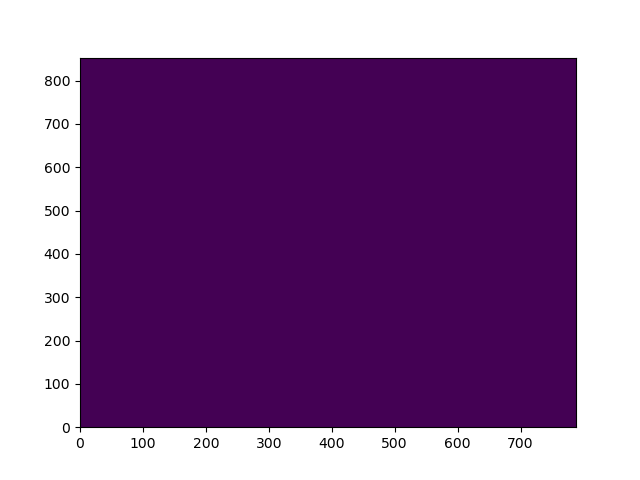

In [107]:
plt.figure()
plt.pcolormesh(ssh_bar_09.ssh_bar)
plt.show()